## Identificación de Líneas Moleculares

In [25]:
%matplotlib inline

import numpy as np
import pandas as pd
import peakutils
import matplotlib.pyplot as plt
import lineid_plot                #to plot lines identification 

from peakutils.plot import plot as pplot
from astroquery.splatalogue import Splatalogue
from astropy import units as u
from lmfit.models import GaussianModel
from scipy import interpolate

In [67]:
# Importamos el mean-spectrum que se ha guardado previamente.
df = pd.read_csv('mean_spectrum.txt', names = ["Frequency", "Flux"])
freq = df['Frequency']
flux = df['Flux']

# Solo para visualizar en plots. Importamos la lista de moleculas previamente identificadas a ojo:
mol = pd.read_csv('mol-lines.csv')
line_label1 = np.array(mol['Species'].astype('str'))
line_wave = np.array(mol['Ordered_Freq_(GHz) (rest frame, redshifted)'].str[:12].astype('float'))
#line_label1, line_wave

[ 1369  2914  3043 13289 13334 13372 13401 13421 13434 13438 13985 14429
 15075 15125 15287 15294 15739 15799 15805 15821 15835 15841 15858 15867
 15876 15900 15907 15923 16409]


(-4, 15)

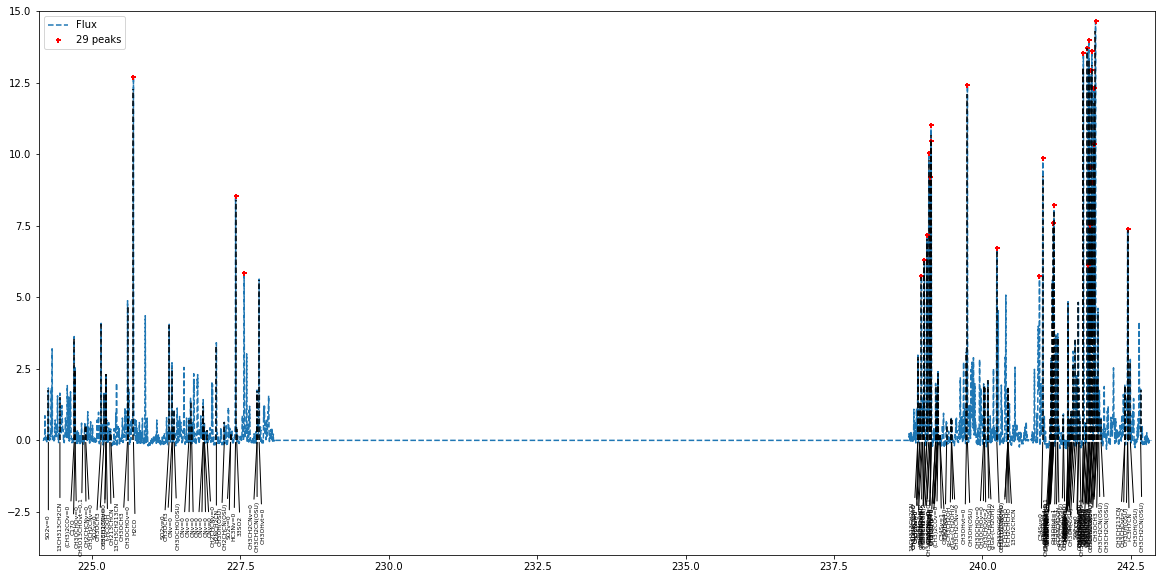

In [69]:
# Con Peakutils buscamos las punto pico de las líneas más brillantes según el límite idicado:
indices = peakutils.indexes(flux, thres=0.400, min_dist=0.1)  # indices son las 'posiciones' de los picos
print(indices)

fig, ax = plt.subplots(figsize=(20,10))
pplot(freq, flux, indices)    
lineid_plot.plot_line_ids(freq, flux, line_wave, line_label1, ax=ax, arrow_tip=0, box_loc=-3,
                          max_iter=300, label1_size=6) #plot the molecular lines
ax.set_xlim(224.1,242.9)
ax.set_ylim(-4,15)

### Extraemos una de las líneas:

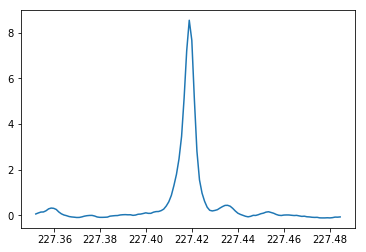

In [70]:
# Este bloque extrae los puntos deseados(i.e. 60) a la derecha e izquierda del pico (linea) elegido: 
lineFreq_list = freq[int(indices[1]-60):int(indices[1]+60)]
lineFlux_list = flux[int(indices[1]-60):int(indices[1]+60)]

#print(fgnew[indices][0], lineFreq_list)
#print(interfl_mean[indices][0], lineFlux_list.max(), lineFlux_list)

plt.plot(lineFreq_list, lineFlux_list)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 35
    # data points      = 120
    # variables        = 3
    chi-square         = 6.837
    reduced chi-square = 0.058
    Akaike info crit   = -337.811
    Bayesian info crit = -329.448
[[Variables]]
    sigma:       0.00267319 +/- 5.59e-05 (2.09%) (init= 0.03873598)
    center:      227.418598 +/- 5.59e-05 (0.00%) (init= 227.4182)
    amplitude:   0.05313672 +/- 0.000962 (1.81%) (init= 8.542555)
    fwhm:        0.00629489 +/- 0.000132 (2.09%)  == '2.3548200*sigma'
    height:      7.93002195 +/- 0.143559 (1.81%)  == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, amplitude)          =  0.577 



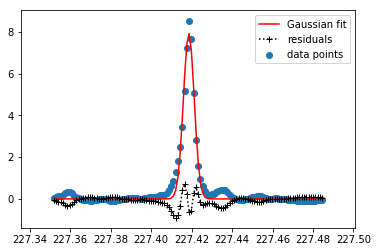

Center and Height:
227.41859886132957 7.930021949664085

Best values from the fit (the amplitud is not the height of the line):
{'sigma': 0.0026731942742042047, 'center': 227.41859886132957, 'amplitude': 0.05313672997362199}

Initial parameters:
{'sigma': 0.03873597782478362, 'center': 227.41818778404993, 'amplitude': 8.5425546409800006}


In [71]:
# Se hace un ajuste gaussiano a la línea extraida con parámetros iniciales: lineFlux_list.max(), 
# lineFreq_list.mean() y lineFreq_list.std()

gmodel = GaussianModel()
params = gmodel.make_params(amplitude=lineFlux_list.max(),
                            center=lineFreq_list.mean(),
                            sigma=lineFreq_list.std())

result = gmodel.fit(lineFlux_list, params, x=lineFreq_list)   # fit a gaussian with parameters from 'params'
residual_gauss = result.residual                              # residuals calculated within the fit
perr = np.sqrt(np.diag(result.covar))                         # error of the 3 parameters calculated in the fit

print(result.fit_report())

# Graficamos el ajuste:
plt.scatter(lineFreq_list, lineFlux_list, label='data points')
plt.plot(lineFreq_list, result.best_fit, 'r-', label='Gaussian fit')
plt.plot(lineFreq_list, residual_gauss, 'k+:', label='residuals')
plt.legend()

plt.show()

# Aqui aún no termino de entender porque la amplitud calculada con el ajuste no es la altura de la linea, la cual 
# se describe con la variable 'height'

print('Center and Height:')
print(result.best_values['center'], result.params['height'].value)
print('\nBest values from the fit (the amplitud is not the height of the line):')
print(result.best_values)
print('\nInitial parameters:')
print(result.init_values)

In [74]:
# Con Astroquery - Splatalogue solo se pueden obtener hasta 1000 rows (i.e. molecules) por 'query', entones no se
# puede usar un rango de frecuencias grande porque la busqueda para cuando llega a las 1000 moleculas.

# Asi que definimos el rango de frequencias a paratir del fwhm del ajuste:
fwhm = result.params['fwhm'].value
low_lim = result.best_values['center'] - fwhm
up_lim = result.best_values['center'] + fwhm

low_lim, result.best_values['center'], up_lim

(227.41230396998878, 227.41859886132957, 227.42489375267036)

In [135]:
# Buscamos la lista de moleculas que pueden estar en el rango de frecuencias de la linea en el Splatalogue database

S2 = Splatalogue.query_lines(low_lim*u.GHz, up_lim*u.GHz, energy_max=500, energy_type='eu_k')
S2.pprint()

# Parametros elegidos: limites inferior y superior para el rango de frecuencias calculado en el bloque anterior con
# el indicado de unidades (GHz) y limitamos el upper-limit de la energia a max 500 K.

molec2 = list(S2['Species'])
name2 = list(S2['Chemical Name'])
Freqrest2 = np.array(S2['Freq-GHz(rest frame,redshifted)'])
Freqrest_err2 = np.array(S2['Freq Err(rest frame,redshifted)'])
print('\n',Freqrest2,'\n\n', molec2)

    Species                    Chemical Name               ... Linelist
---------------- ----------------------------------------- ... --------
          CH3OOH                           Methyl peroxide ...      JPL
 C2H5OOCH-gauche                             Ethyl formate ...      JPL
       c-H13COOH                               Formic acid ...      JPL
          O81BrO                           Bromine dioxide ...      JPL
         HONO18O                               Nitric acid ...      JPL
            C3H8                                   Propane ...      JPL
       c-C2H418O Oxirane, ethylene oxide, oxa-cyclopropane ...     CDMS
       c-C2H418O Oxirane, ethylene oxide, oxa-cyclopropane ...     CDMS
 H2NCH2COOH-Iv=0                                   Glycine ...     CDMS
 H2NCH2COOH-Iv=0                                   Glycine ...     CDMS
             ...                                       ... ...      ...
         HC3Nv=0                            Cyanoacetylene ...  

In [130]:
# Al limitar la busqueda a solo la lista de frecuencias recomendadas por NRAO con 'only_NRAO_recommended=True', 
# la lista se hace mucho más pequeña, y solo toma moleculas de la lista mas reciente del JPL, CDMS, SLAIM o 
# Lovas/NIST:

S = Splatalogue.query_lines(low_lim*u.GHz, up_lim*u.GHz, energy_max=500, energy_type='eu_k',
                            only_NRAO_recommended=True)
S.pprint()

molec = list(S['Species'])
name = list(S['Chemical Name'])

# La base de datos puede entregar la frecuencia teorica o la frecuencia medida en laboratorio. 
# En el caso de los catalogos JPL and CDMS aparece una o la otra (si se tiene), pero nunca ambas a la vez; de allí 
# que aparezcan frecuencias igual a cero en la busqueda del bloque anterior (y como se ve a continuacion), pues 
# inicialmente yo estaba eligiendo las frecuencias teoricas. 

print('\n',np.array(S['Freq-GHz(rest frame,redshifted)']))  #lista de frecuencias teoricas
print(np.array(S['Meas Freq-GHz(rest frame,redshifted)']))  #lista de frecuencias medidas en lab.

# para evitar estos ceros, y las malas aproximaciones a la frecuencia central, pense en este condicional:
Freqrest = []
Freqrest_err = []
for i in range(len(S['Freq-GHz(rest frame,redshifted)'])):
    if np.array(S['Freq-GHz(rest frame,redshifted)'])[i] == 0:
        Freqrest.append(np.array(S['Meas Freq-GHz(rest frame,redshifted)'])[i])
        Freqrest_err.append(np.array(S['Meas Freq Err(rest frame,redshifted)'])[i])
    else:
        Freqrest.append(np.array(S['Freq-GHz(rest frame,redshifted)'])[i])
        Freqrest_err.append(np.array(S['Freq Err(rest frame,redshifted)'])[i])

Freqrest, Freqrest_err

  Species    Chemical Name   ...  E_U (K)  Linelist
----------- ---------------- ... --------- --------
(CH3)2COv=0          Acetone ... 275.11953      JPL
    CH2DCCH Methyl Acetylene ...  87.12347      JPL
    HC3Nv=0   Cyanoacetylene ... 141.89637     CDMS

 [ 227.4147194  227.4161834    0.       ]
[   0.          0.        227.418905]


([227.4147194, 227.41618339999999, 227.418905],
 [0.00051460000000000004, 0.011742799999999999, 1.0000000000000001e-05])

In [131]:
# En este bloque se busca coincidencias entre la lista de frecuencias de las moleculas buscadas en Splatalogue y
# la freqcuencia central del ajuste gaussiano

def common_frequencies(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    if (a_set & b_set): 
        print(a_set & b_set) 
    else: 
        print("No common elements")

Freqrest = np.array(Freqrest)
Freqrest_err = np.array(Freqrest_err)
center = np.array([result.best_values['center']])

common_frequencies(Freqrest,center) 
common_frequencies(Freqrest-Freqrest_err,center) 
common_frequencies(Freqrest+Freqrest_err,center) 

# Con esta dos lineas tambien buscamos alguna coincidencia entre la lista de frecuencias de Splatalogue y la 
# frecuencia pico encontrada con Peakutils
common_frequencies(Freqrest,freq[indices])
common_frequencies(Freqrest-Freqrest_err,freq[indices])
common_frequencies(Freqrest+Freqrest_err,freq[indices])

No common elements
No common elements
No common elements
No common elements
No common elements
No common elements


In [132]:
# Dado que es prácticamente imposible encontrar coincidencias entre la lista de frecuencias de Splatalogue y la 
# frecuencia central del ajuste gaussiano de la linea, se eligira de entre la lista la frecuencia mas cercana a la
# freuencia central.

# Con esta linea puedo obtener no solo la frecuencia mas cercana, sino tambien, la posicion en el espectro de dicha
# frecuencia:
approxfreq_line = min(enumerate(Freqrest), key=lambda x: abs(x[1]-result.best_values['center']))
print(approxfreq_line,', recordar centro ajuste:',result.best_values['center'])                                        

common_frequencies(Freqrest,np.array([approxfreq_line[1]]))   # Esto es solo para confirmar

(2, 227.418905) , recordar centro ajuste: 227.41859886132957
{227.418905}


In [139]:
# Verificamos con la posicion de la frecuencia encontrada en el bloque anterior, cual es identidad de la molecula
# más cercana a la frecuencia central del ajuste gaussiano realizado a la linea.
print(molec[approxfreq_line[0]], name[approxfreq_line[0]], 
      Freqrest[approxfreq_line[0]], Freqrest_err[approxfreq_line[0]])

# Es importante tener en cuenta que si no usamos el parametro 'only_NRAO_recommended=True' en la busqueda en
# Splatalogue, la lista de moleculas seria mas amplia, y por ende, la identificacion cambia.
approxfreq_line2 = min(enumerate(Freqrest2), key=lambda x: abs(x[1]-result.best_values['center']))

print(molec2[approxfreq_line2[0]], name2[approxfreq_line2[0]], 
      Freqrest2[approxfreq_line2[0]], Freqrest_err2[approxfreq_line2[0]])

HC3Nv=0 Cyanoacetylene 227.418905 1e-05
C3H8 Propane 227.4188616 2.01e-05


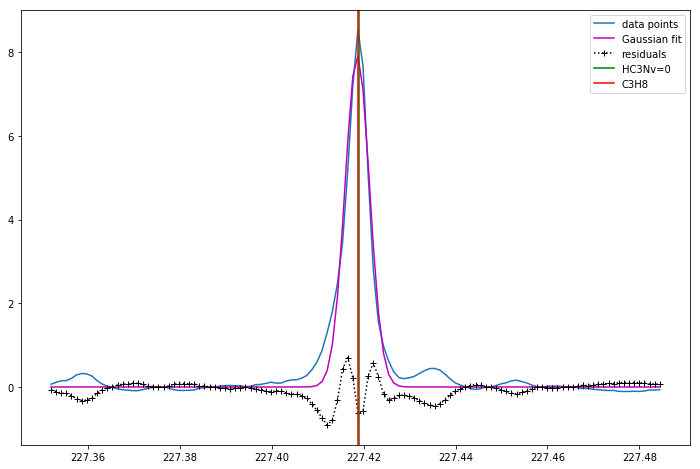

In [145]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(lineFreq_list, lineFlux_list, label='data points')
ax.plot(lineFreq_list, result.best_fit, 'm-', label='Gaussian fit')
ax.plot(lineFreq_list, residual_gauss, 'k+:', label='residuals')
ax.axvline(x=Freqrest[approxfreq_line[0]], color='g' , label=(molec[approxfreq_line[0]]))
ax.axvline(x=Freqrest2[approxfreq_line2[0]], color='r' , label=(molec2[approxfreq_line2[0]]))

ax.legend()

plt.show()

### Repetimos el proceso para varias lineas

In [148]:
def extract_line(index, freq, flux):
    
    '''Extract one line from the mean spectrum.
    
    Parameter:
    ----------
        index: int,
            Position of the line in the spectrum.
            
        freq: array,
            Aray of frequencies of the spectrum.
   
        flux: int,
            Array of fluxes of the spectrum.
    Return:
    ----------
       lineFreq_list: array,
           Array of frequencies around the center
           frequency indicated by the index position. 
           
       lineFlux_list: array,
           Array of fluxes around the center
           frequency indicated by the index position.
    '''

    lineFreq_list = freq[int(index-10):int(index+10)]
    lineFlux_list = flux[int(index-10):int(index+10)]
    
    return lineFreq_list, lineFlux_list


linesFreq_lists = []
linesFlux_lists = []
for i in range(len(indices)):
    
    lineFreq_list, lineFlux_list = extract_line(indices[i], freq, flux)   
    
    linesFreq_lists += [lineFreq_list.tolist()]
    linesFlux_lists += [lineFlux_list.tolist()]
    
linesFreq_lists = np.array(linesFreq_lists)
linesFlux_lists = np.array(linesFlux_lists)  

print(linesFreq_lists.shape, linesFlux_lists.shape)

(29, 20) (29, 20)


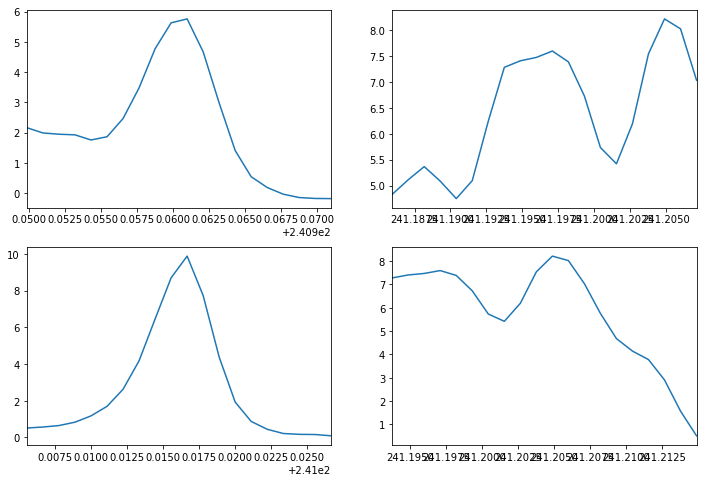

In [150]:
# Graficamos cuatro (algunos de los que presenta más de un pico) para visualizar los datos
fig, ax = plt.subplots(2,2, sharex=False, figsize=(12, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[0,0].plot(linesFreq_lists[12], linesFlux_lists[12])
ax[1,0].plot(linesFreq_lists[13], linesFlux_lists[13])
ax[0,1].plot(linesFreq_lists[14], linesFlux_lists[14])
ax[1,1].plot(linesFreq_lists[15], linesFlux_lists[15])
ax[0,0].set_xlim(lineFreq_list_xlims[12])
ax[1,0].set_xlim(lineFreq_list_xlims[13])
ax[0,1].set_xlim(lineFreq_list_xlims[14])
ax[1,1].set_xlim(lineFreq_list_xlims[15])

plt.show()

In [153]:
def fit_line(lineFreq_list,lineFlux_list):
    '''Extract one line from the mean spectrum.
    
    Parameter:
    ----------
        lineFreq_list: array,
           Array of frequencies around the center
           frequency indicated by the index position. 
           
       lineFlux_list: array,
           Array of fluxes around the center
           frequency indicated by the index position.
    Return:
    ----------
       lineFreq_list: array,
           Array of frequencies around the center
           frequency indicated by the index position. 
           
       lineFlux_list: array,
           Array of fluxes around the center
           frequency indicated by the index position.
    '''
    gmodel = GaussianModel()
    params = gmodel.make_params(amplitude=lineFlux_list.max(),
                                center=lineFreq_list.mean(),
                                sigma=lineFreq_list.std())

    result = gmodel.fit(lineFlux_list, params, x=lineFreq_list)   # fit a gaussian with parameters from 'params'

    print('\nResults for line in position:',lineFreq_list.mean())
    print(result.fit_report())
    
    return result

ResultsGauss_list = []
ResidualGauss_list = []
Centerfreq_list = []
freqLow_lim = []
freqUp_lim = []
for i in range(len(linesFreq_lists)):
    r = fit_line(linesFreq_lists[i],linesFlux_lists[i])
    
    result = r.best_fit    
    residual_gauss = r.residual                              # residuals calculated within the fit
    #perr = np.sqrt(np.diag(r.covar))                         # error of the 3 parameters calculated in the fit
    center = r.best_values['center']
    fwhm = r.params['fwhm'].value
    low_lim = center - fwhm
    up_lim = center + fwhm
    
    Centerfreq_list.append(center)
    freqLow_lim.append(low_lim)
    freqUp_lim.append(up_lim)
    
    ResultsGauss_list += [result.tolist()]
    ResidualGauss_list += [residual_gauss.tolist()]
ResultsGauss_list = np.array(ResultsGauss_list)
ResidualGauss_list = np.array(ResidualGauss_list)


Results for line in position: 225.697705035
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 20
    # variables        = 3
    chi-square         = 9.776
    reduced chi-square = 0.575
    Akaike info crit   = -8.316
    Bayesian info crit = -5.329
[[Variables]]
    sigma:       0.00273076 +/- 0.000116 (4.23%) (init= 0.006421222)
    center:      225.697679 +/- 0.000116 (0.00%) (init= 225.6977)
    amplitude:   0.08325919 +/- 0.003051 (3.66%) (init= 12.71652)
    fwhm:        0.00643045 +/- 0.000272 (4.23%)  == '2.3548200*sigma'
    height:      12.1634866 +/- 0.445762 (3.66%)  == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, amplitude)          =  0.577 


Results for line in position: 227.418187784
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 20
    # variables        = 3
    chi-square         = 4.832
    reduc

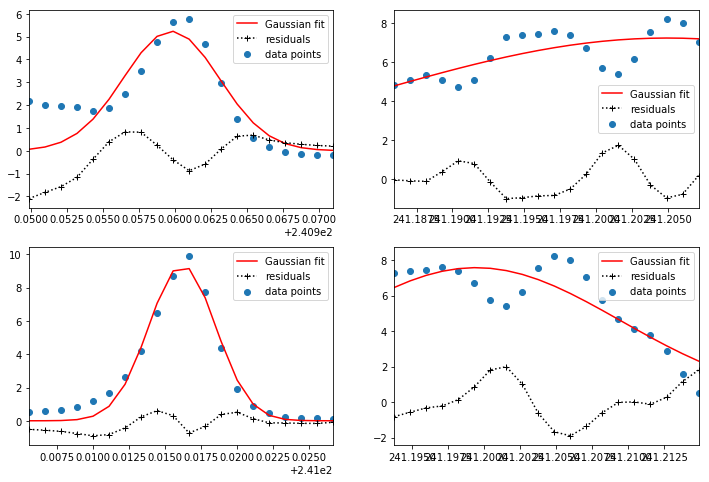

In [154]:
#lets try a couple of plots:
fig, ax = plt.subplots(2,2, sharex=False, figsize=(12, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[0,0].scatter(linesFreq_lists[12], linesFlux_lists[12], label='data points')
ax[0,0].plot(linesFreq_lists[12], ResultsGauss_list[12], 'r-', label='Gaussian fit')
ax[0,0].plot(linesFreq_lists[12], ResidualGauss_list[12], 'k+:', label='residuals')
ax[0,0].legend()
ax[1,0].scatter(linesFreq_lists[13], linesFlux_lists[13], label='data points')
ax[1,0].plot(linesFreq_lists[13], ResultsGauss_list[13], 'r-', label='Gaussian fit')
ax[1,0].plot(linesFreq_lists[13], ResidualGauss_list[13], 'k+:', label='residuals')
ax[1,0].legend()
ax[0,1].scatter(linesFreq_lists[14], linesFlux_lists[14], label='data points')
ax[0,1].plot(linesFreq_lists[14], ResultsGauss_list[14], 'r-', label='Gaussian fit')
ax[0,1].plot(linesFreq_lists[14], ResidualGauss_list[14], 'k+:', label='residuals')
ax[0,1].legend()
ax[1,1].scatter(linesFreq_lists[15], linesFlux_lists[15], label='data points')
ax[1,1].plot(linesFreq_lists[15], ResultsGauss_list[15], 'r-', label='Gaussian fit')
ax[1,1].plot(linesFreq_lists[15], ResidualGauss_list[15], 'k+:', label='residuals')
ax[1,1].legend()

ax[0,0].set_xlim(lineFreq_list_xlims[12])
ax[1,0].set_xlim(lineFreq_list_xlims[13])
ax[0,1].set_xlim(lineFreq_list_xlims[14])
ax[1,1].set_xlim(lineFreq_list_xlims[15])

plt.show()

In [164]:
def lineSearch_Splatalogue(min_freq, max_freq):
 
    S = Splatalogue.query_lines(min_freq*u.GHz, max_freq*u.GHz, energy_max=500, energy_type='eu_k', 
                                only_NRAO_recommended=True)
    #S.pprint()
    
    return S        

freqLow_lim
freqUp_lim

Splat_linesFreqrest_list = []
Splat_linesFreqresterr_list = []
molec_list = []
molecName_list = []
    
for i in range(len(freqLow_lim)):
    
    low_lim = freqLow_lim[i]
    up_lim = freqUp_lim[i]
    
    S = lineSearch_Splatalogue(low_lim,up_lim)
    
    molec_list += [S['Species'].tolist()]
    molecName_list += [S['Chemical Name'].tolist()]
    
    Freqrest = []
    Freqrest_err = []
    for j in range(len(S)):
        if np.array(S['Freq-GHz(rest frame,redshifted)'])[j] == 0:
            Freqrest.append(np.array(S['Meas Freq-GHz(rest frame,redshifted)'])[j])
            Freqrest_err.append(np.array(S['Meas Freq Err(rest frame,redshifted)'])[j])
        else:
            Freqrest.append(np.array(S['Freq-GHz(rest frame,redshifted)'])[j])
            Freqrest_err.append(np.array(S['Freq Err(rest frame,redshifted)'])[j])
    
    Splat_linesFreqrest_list += [Freqrest] 
    Splat_linesFreqresterr_list += [Freqrest_err]
                               
Splat_linesFreqrest_list = np.array(Splat_linesFreqrest_list) 
molec_list = np.array(molec_list)
molecName_list = np.array( molecName_list)   

#print(Splat_linesFreqrest_list[28],S['Freq-GHz(rest frame,redshifted)'])

In [166]:
def common_frequencies(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    if (a_set & b_set): 
        print(a_set & b_set) 
    else: 
        print("No common elements")
     
        
list_approxfreq = []

for i in range(len(Splat_linesFreqrest_list)):
    Splat_linfreqs = tuple(Splat_linesFreqrest_list[i])
    
    # Primer intento de encontrar un 'match'
    print('\n---line at ',Centerfreq_list[i])
    common_frequencies(Splat_linfreqs,np.array([Centerfreq_list[i]]))  
    
    approxfreq_line = min(enumerate(Splat_linesFreqrest_list[i]), key=lambda x: abs(x[1]-Centerfreq_list[i]))
    
    # Para verificar la frecuencia mas proxima elegida
    common_frequencies(Splat_linfreqs,approxfreq_line)   
    
    print('-> This line is: ',molec_list[i][approxfreq_line[0]])
    #print(molec_list[i])
    
    list_approxfreq.append(approxfreq_line)
#print(list_approxfreq[0][1])


---line at  225.6976793395785
No common elements
{225.69777500000001}
-> This line is:  H2CO

---line at  227.41859848270417
No common elements
{227.418905}
-> This line is:  HC3Nv=0

---line at  227.56190119731704
No common elements
{227.56187499999999}
-> This line is:  CH3OCHO(OSU)

---line at  238.97278380463496
No common elements
{238.97238949999999}
-> This line is:  CH3CNv=0

---line at  239.02132860022087
No common elements
{239.02102719999999}
-> This line is:  CH3OCH3

---line at  239.06411660399075
No common elements
{239.06429879999999}
-> This line is:  CH3CNv=0

---line at  239.09643394239978
No common elements
{239.09649659999999}
-> This line is:  CH3CNv=0

---line at  239.11951813479595
No common elements
{239.11950440000001}
-> This line is:  CH3CNv=0

---line at  239.13541069212764
No common elements
{239.13502500000001}
-> This line is:  13CH3CH213CN

---line at  239.1354683618911
No common elements
{239.13502500000001}
-> This line is:  13CH3CH213CN

---line at  2

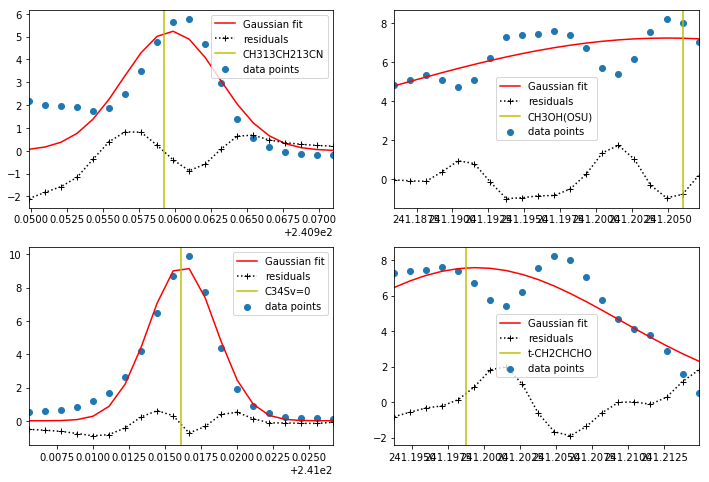

In [167]:
fig, ax = plt.subplots(2,2, sharex=False, figsize=(12, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[0,0].scatter(linesFreq_lists[12], linesFlux_lists[12], label='data points')
ax[0,0].plot(linesFreq_lists[12], ResultsGauss_list[12], 'r-', label='Gaussian fit')
ax[0,0].plot(linesFreq_lists[12], ResidualGauss_list[12], 'k+:', label='residuals')
ax[0,0].axvline(x=Splat_linesFreqrest_list[12][list_approxfreq[12][0]], color='y' , 
           label=(molec_list[12][list_approxfreq[12][0]]))
ax[0,0].legend()
ax[1,0].scatter(linesFreq_lists[13], linesFlux_lists[13], label='data points')
ax[1,0].plot(linesFreq_lists[13], ResultsGauss_list[13], 'r-', label='Gaussian fit')
ax[1,0].plot(linesFreq_lists[13], ResidualGauss_list[13], 'k+:', label='residuals')
ax[1,0].axvline(x=Splat_linesFreqrest_list[13][list_approxfreq[13][0]], color='y' , 
           label=(molec_list[13][list_approxfreq[13][0]]))
ax[1,0].legend()
ax[0,1].scatter(linesFreq_lists[14], linesFlux_lists[14], label='data points')
ax[0,1].plot(linesFreq_lists[14], ResultsGauss_list[14], 'r-', label='Gaussian fit')
ax[0,1].plot(linesFreq_lists[14], ResidualGauss_list[14], 'k+:', label='residuals')
ax[0,1].axvline(x=Splat_linesFreqrest_list[14][list_approxfreq[14][0]], color='y' , 
           label=(molec_list[14][list_approxfreq[14][0]]))
ax[0,1].legend()
ax[1,1].scatter(linesFreq_lists[15], linesFlux_lists[15], label='data points')
ax[1,1].plot(linesFreq_lists[15], ResultsGauss_list[15], 'r-', label='Gaussian fit')
ax[1,1].plot(linesFreq_lists[15], ResidualGauss_list[15], 'k+:', label='residuals')
ax[1,1].axvline(x=Splat_linesFreqrest_list[15][list_approxfreq[15][0]], color='y' , 
           label=(molec_list[15][list_approxfreq[15][0]]))
ax[1,1].legend()

ax[0,0].set_xlim(lineFreq_list_xlims[12])
ax[1,0].set_xlim(lineFreq_list_xlims[13])
ax[0,1].set_xlim(lineFreq_list_xlims[14])
ax[1,1].set_xlim(lineFreq_list_xlims[15])

plt.show()